## ACP 166: Datos abiertos para ciudades resilientes
### Unidad 3: Riesgo climático
#### 12 de noviembre 2025

Objetivos

In [ ]:
# pull GHSL pop data for downscaling
# pull Census data for vulnerability
# look *only* at the urban area of pergamino as our AOI, and at only the past 3 years max LST--should go much faster

In [1]:
import geopandas as gpd

from pathlib import Path

import requests


from io import BytesIO
from owslib.wfs import WebFeatureService

import planetary_computer
import pystac_client
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load
import matplotlib.pyplot as plt


from dask.diagnostics import ProgressBar
import rioxarray as rio


USE_CRS = "EPSG:5347"
CRS_WGS84 = "EPSG:4326"

RUTA_BASE = Path("/home/nissim/Documents/dev/datos-escala-humana/")
RUTA_DATOS = RUTA_BASE / "data"

In [2]:
def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if (RUTA_DATOS / "municipios.geojson").exists():
    munis = gpd.read_file(RUTA_DATOS / "municipios.geojson")
else:
    munis = wfs_to_gdf(wfs_url=base_url, layer_name="ign:municipio", srs="EPSG:4326")

pergamino = munis[munis["nam"] == "Pergamino"]
pergamino = pergamino.to_crs(USE_CRS)

bbox_pergamino_4326 = pergamino.to_crs(CRS_WGS84).total_bounds

In [3]:
# Base WMS URL (clean up the malformed URL)
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:aglomerados_urbanos"

# Build GetFeature request
bbox_pergamino = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox_pergamino[0]},{bbox_pergamino[1]},{bbox_pergamino[2]},{bbox_pergamino[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    aglomerados_urbanos = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(aglomerados_urbanos)} features")
    print(f"CRS: {aglomerados_urbanos.crs}")

    # Clip to exact Pergamino boundary
    aglomerados_urbanos = aglomerados_urbanos.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Loaded 166 features
CRS: EPSG:4326


In [4]:
aglomerados_urbanos.head()

,id,area,metodologia,clasificacion,distrito,fecha_actualizacion,fuente,definicion,descargo_responsabilidad,observaciones,seccion,geometry
0,160,1846.04,Los aglomerados son manchas territoriales cont...,urbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,4,"POLYGON ((5447824.192 6250167.097, 5447826.956..."
1,28,0.25,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,2,"POLYGON ((5446014.821 6253170.109, 5446036.84 ..."
2,30,2.24,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,1,"POLYGON ((5444072.648 6251627.258, 5444191.506..."
3,32,0.09,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,1,"POLYGON ((5444305.24 6251233.481, 5444294.2 62..."
4,41,0.18,Los aglomerados son manchas territoriales cont...,periurbana,Pergamino,07.2024,imágenes aéreas,Se entiende como un continuo urbano donde las ...,No se deberán tomar estos polígonos como datos...,None,2,"POLYGON ((5446217.105 6253403.15, 5446201.686 ..."


<Axes: >

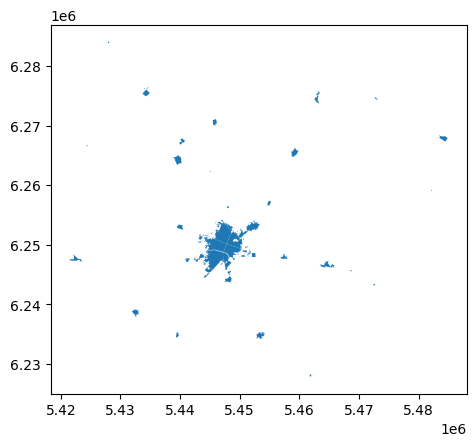

In [5]:
aglomerados_urbanos.plot()

In [6]:
aglomerados_urbanos[aglomerados_urbanos["clasificacion"] == "urbana"].shape

(6, 12)

<Axes: >

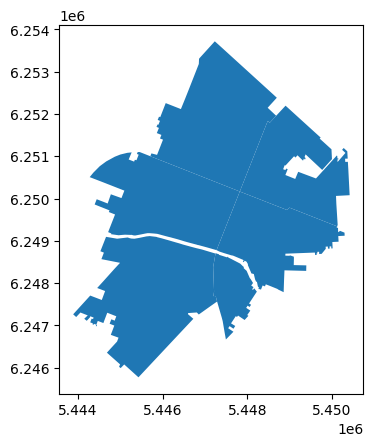

In [7]:
aglomerados_urbanos[aglomerados_urbanos["clasificacion"] == "urbana"].plot()

In [8]:
area_urbana = aglomerados_urbanos[aglomerados_urbanos["clasificacion"] == "urbana"]

In [9]:
bbox_area_urbana = area_urbana.to_crs("EPSG:4326").total_bounds

## LST via Landsat

In [10]:
# Connect to Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

cluster = LocalCluster(
    processes=True,  # Critical: use processes, not threads
    n_workers=8,  # Use half your cores for workers
    threads_per_worker=2,  # 2 threads per worker = 16 total
    memory_limit="6GB",  # 8 workers × 6GB = 48GB, leaves headroom
)
client = Client(cluster)
print(f"Dask dashboard: {client.dashboard_link}")
configure_rio(cloud_defaults=True, client=client)

# query for 5 years
bbox = bbox_area_urbana
datetime = "2020-01-01/2025-01-01"
cloudy_less_than = 20

query = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34481 instead
  warnings.warn(


Dask dashboard: http://127.0.0.1:34481/status
Found: 352 datasets


This currently takes about 5 minutes. I'll have to play around with it in Colab to see what the timing is like there--ideally, I'd like to get it down to around 2. Can probably just cut another year, although that carries certain issues of data quality. Maybe it's good for them to see a workflow take that long to run.

In [11]:
# Define output file path (same directory as notebook)
import os

notebook_dir = Path(os.path.dirname(os.path.abspath("pergamino.ipynb")))
lst_tif_path = notebook_dir / "LST_max_pergamino_area_urbana_TESTFORTALLER.tif"

# Check if file exists, otherwise compute
if lst_tif_path.exists():
    print(f"Loading existing LST data from {lst_tif_path}")
    LST_max_computed = rio.open_rasterio(lst_tif_path)
    # Squeeze out any extra dimensions if needed
    if len(LST_max_computed.dims) > 2:
        LST_max_computed = LST_max_computed.squeeze()
else:
    print("Computing LST from scratch...")
    # Load only thermal band and QA band
    crs = "epsg:3857"
    yy = stac_load(
        items,
        bands=("lwir11", "qa_pixel"),
        crs=crs,
        resolution=30,
        chunks={"time": 10},  # Process in chunks of 10 time steps
        groupby="landsat:scene_id",
        bbox=bbox,
    )

    # Create cloud mask function
    def create_cloud_mask(qa_band):
        """Mask clouds and cloud shadows"""
        # Bit 3: Cloud, Bit 4: Cloud Shadow
        cloud_mask = (qa_band & 0b11000) == 0
        return cloud_mask

    # Apply cloud mask
    yy_masked = yy.where(create_cloud_mask(yy.qa_pixel))

    # Convert thermal band to LST in Celsius
    LST_kelvin = yy_masked["lwir11"] * 0.00341802 + 149.0
    LST_celsius = LST_kelvin - 273.15

    # Calculate maximum LST per pixel over all time steps
    LST_max = LST_celsius.max(dim="time")

    # Before compute()
    print("Computing maximum LST...")
    print(f"Dashboard: {client.dashboard_link}")
    with ProgressBar():
        LST_max_computed = LST_max.compute()

    # Save to file
    print(f"Saving LST data to {lst_tif_path}")
    LST_max_computed.rio.to_raster(lst_tif_path)

Loading existing LST data from /home/nissim/Documents/dev/datos-escala-humana/es/riesgo-climatico/LST_max_pergamino_area_urbana_TESTFORTALLER.tif


In [43]:
# First, clip LST to urban area
# Ensure area_urbana is in the same CRS as LST_max_computed
if area_urbana.crs != LST_max_computed.rio.crs:
    area_urbana_lst_crs = area_urbana.to_crs(LST_max_computed.rio.crs)
else:
    area_urbana_lst_crs = area_urbana

# Clip LST to urban area
LST_urban = LST_max_computed.rio.clip(
    area_urbana_lst_crs.geometry.values,
    from_disk=True,
)

In [51]:
LST_urban.rio.to_raster("LST_urban_TEST.tif")

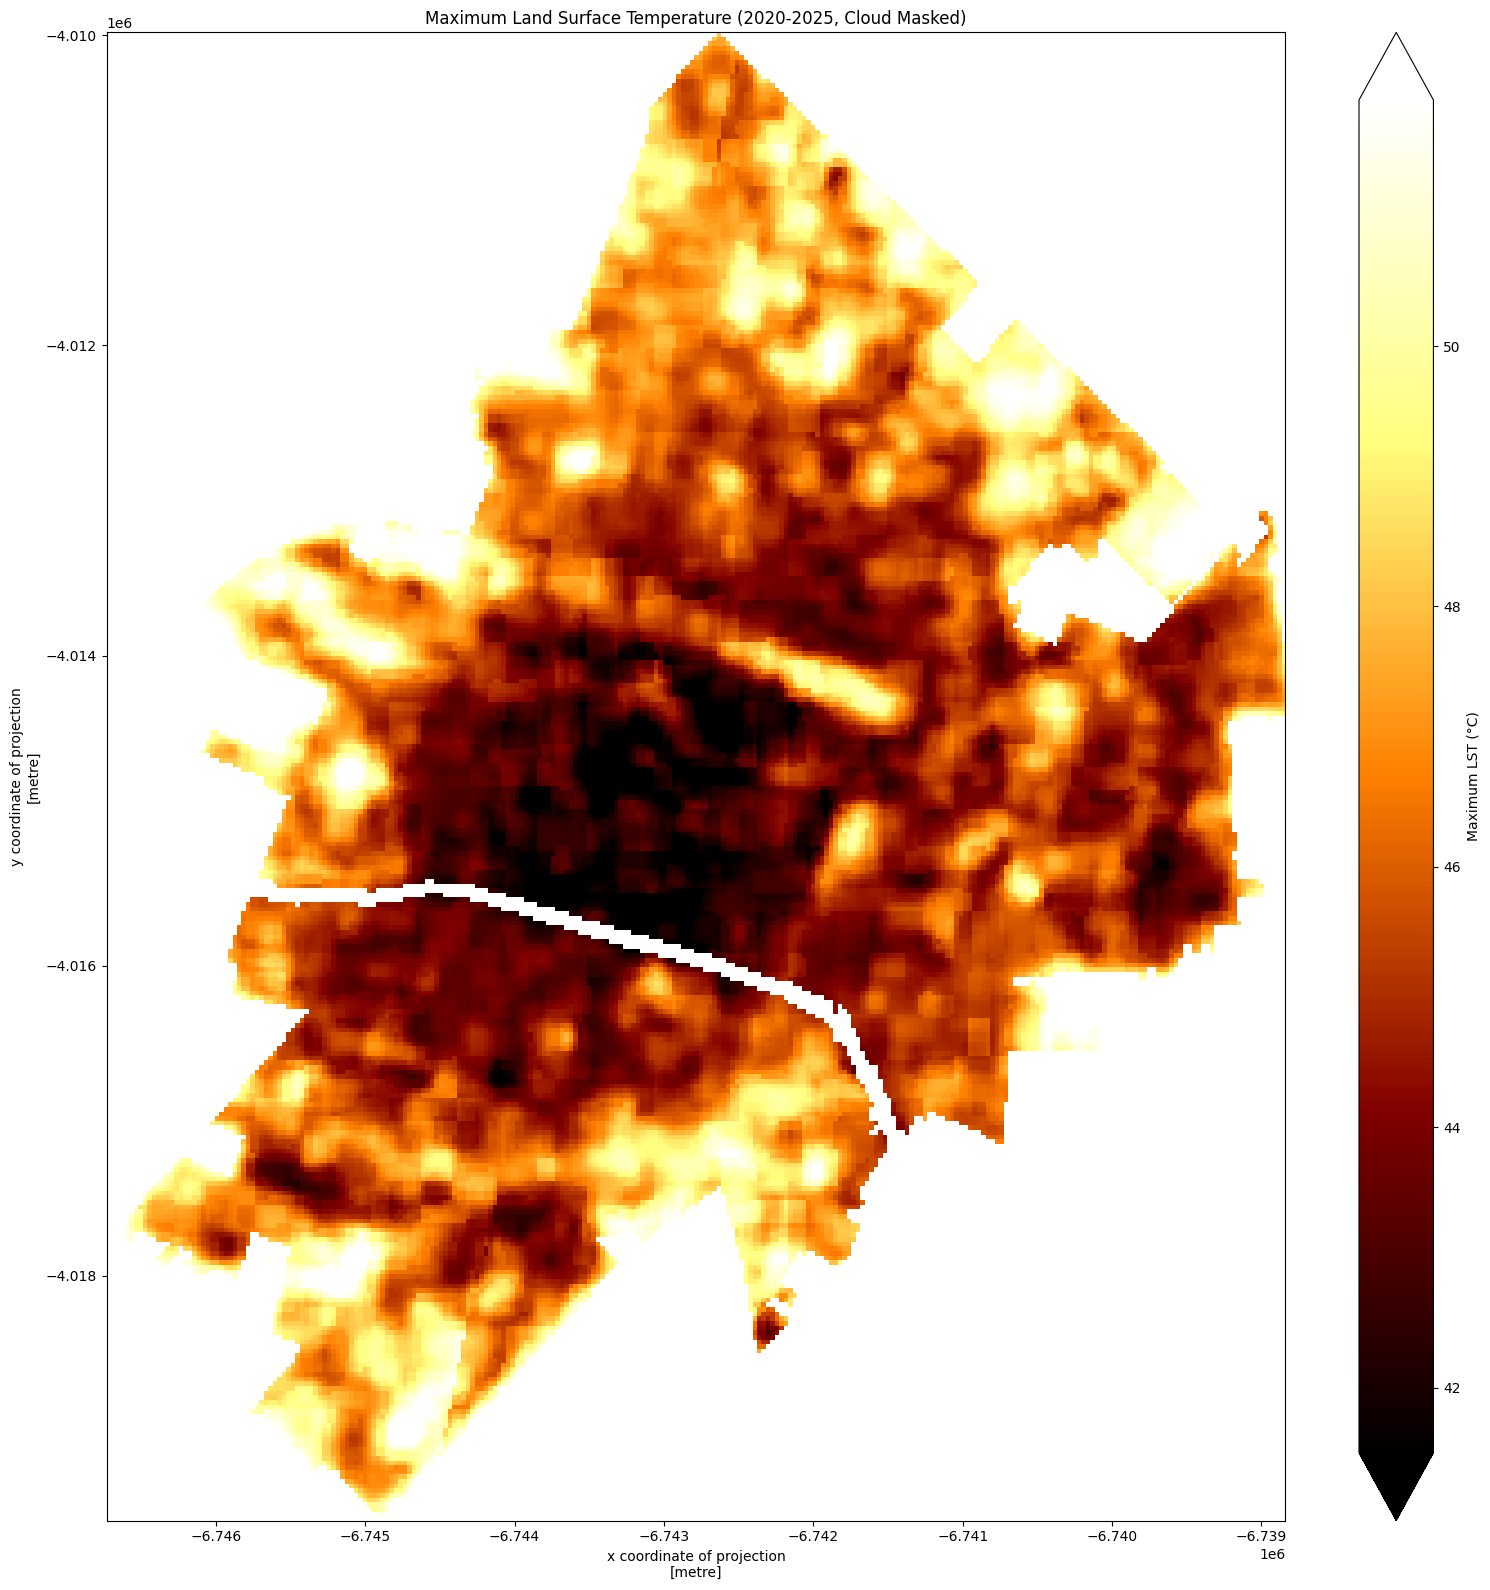

In [45]:
# Plot the result
fig, ax = plt.subplots(figsize=(16, 16))
LST_urban.plot.imshow(
    ax=ax,
    cmap="afmhot",
    cbar_kwargs={"label": "Maximum LST (°C)"},
    robust=True,  # Use 2nd and 98th percentiles for color scaling
)
ax.set_title("Maximum Land Surface Temperature (2020-2025, Cloud Masked)")
plt.tight_layout()
plt.show()

In [46]:
# Print some statistics
print("\nMaximum LST Statistics:")
print(f"  Overall max: {float(LST_urban.max().values):.2f}°C")
print(f"  Overall min: {float(LST_urban.min().values):.2f}°C")
print(f"  Mean of maximums: {float(LST_urban.mean().values):.2f}°C")
print(f"  Median of maximums: {float(LST_urban.median().values):.2f}°C")


Maximum LST Statistics:
  Overall max: 54.43°C
  Overall min: 38.88°C
  Mean of maximums: 46.10°C
  Median of maximums: 45.82°C


In [ ]:
# print histogram
# print quantile breaks
# add interactive map over sateliite basemap
# what kind of observations can you make about the places with the highest LST?

## Exposure

In [ ]:
# pull in GHSL data
# downscale the census data with it

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import rasterize
from io import BytesIO
from owslib.wfs import WebFeatureService

import rioxarray
import contextily as ctx
from shapely.geometry import box
import xarray as xr


aoi = area_urbana

# URL del archivo GHSL que contiene los datos de población
ghsl_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/tiles/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.zip"

# Crear ruta virtual para acceder al archivo ZIP remoto sin descargarlo completamente
# vsizip permite leer archivos dentro de un ZIP, vsicurl permite leer desde una URL
vsi_path = f"/vsizip/vsicurl/{ghsl_url}/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif"

# TODO: cargar el ráster GHSL usando rioxarray.open_rasterio()
#       - usar la ruta virtual vsi_path creada arriba
#       - usar chunks de 2048x2048 píxeles para leer el archivo en bloques (esto permite trabajar con archivos grandes sin cargar todo en memoria)
ghsl = rio.open_rasterio(
    vsi_path,
    chunks={"x": 2048, "y": 2048},
)

# Reproject AOI to match GHSL CRS (vector reprojection is fast)
aoi_54009 = aoi.to_crs("ESRI:54009")

# Now clip with reprojected AOI
ghsl_clipped = ghsl.rio.clip(
    aoi_54009.geometry.values,
    from_disk=True,
)

ghsl_clipped = ghsl_clipped.rio.reproject(USE_CRS)
ghsl_masked = ghsl_clipped.where(ghsl_clipped > 0)

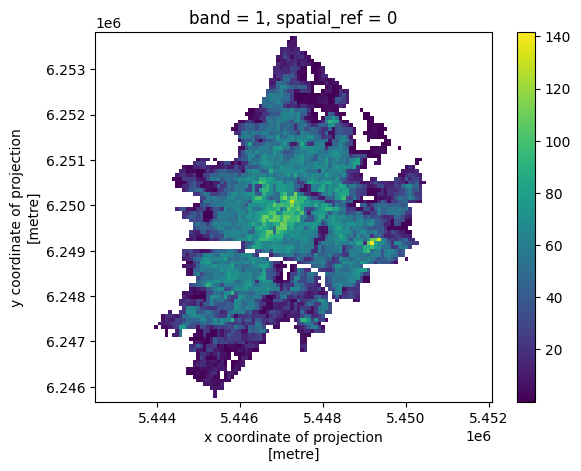

In [32]:
ghsl_masked.plot()

In [24]:
import duckdb
import pandas as pd
import geopandas as gpd

# Setup DuckDB and query
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",
    "LOAD spatial",
    "INSTALL httpfs",
    "LOAD httpfs",
    "SET s3_region='us-east-2'",  # Note: different region for your data
]:
    con.execute(cmd)

temp_file = "privacion_data.parquet"

WGS84_CRS = "EPSG:4326"

bounds = aoi.to_crs(WGS84_CRS).total_bounds

query = f"""
COPY (
    WITH privacion_data AS (
        SELECT 
            id_geo,
            SUM(CASE WHEN valor_categoria IN ('2', '3', '4') THEN conteo ELSE 0 END) AS hogares_con_privacion,
            SUM(conteo) AS total_hogares,
            ROUND((hogares_con_privacion * 100.0) / total_hogares, 2) AS porcentaje_privacion
        FROM 's3://arg-fulbright-data/censo-argentino-2022/censo-2022-largo.parquet'
        WHERE codigo_variable = 'HOGAR_IPMH'
        GROUP BY id_geo
        HAVING total_hogares > 0
    )
    SELECT 
        g.cod_2022,
        g.prov,
        g.depto, 
        g.pob_tot_p,
        g.geometry,
        p.hogares_con_privacion,
        p.total_hogares,
        p.porcentaje_privacion
    FROM 's3://arg-fulbright-data/censo-argentino-2022/radios-2022.parquet' g
    JOIN privacion_data p ON g.cod_2022 = p.id_geo
    WHERE ST_XMax(g.geometry) >= {bounds[0]} 
      AND ST_XMin(g.geometry) <= {bounds[2]}
      AND ST_YMax(g.geometry) >= {bounds[1]} 
      AND ST_YMin(g.geometry) <= {bounds[3]}
) TO '{temp_file}' (FORMAT PARQUET);
"""

con.execute(query)
df = pd.read_parquet(temp_file)
df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="4326")

gdf = gdf.to_crs(USE_CRS).clip(aoi)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [25]:
gdf.head()

,COD_2022,PROV,DEPTO,POB_TOT_P,geometry,hogares_con_privacion,total_hogares,porcentaje_privacion
92,066232209,06,623,16,"POLYGON ((5448864.555 6247926.574, 5448866.211...",3.0,5.0,60.00
77,066232208,06,623,914,"MULTIPOLYGON (((5448874.526 6248177.937, 54488...",149.0,305.0,48.85
123,066232207,06,623,976,"POLYGON ((5448747.023 6248145.068, 5448720.107...",130.0,328.0,39.63
76,066230410,06,623,1045,"POLYGON ((5448898.049 6248587.992, 5448894.554...",122.0,337.0,36.20
42,066232206,06,623,439,"MULTIPOLYGON (((5449300.404 6248293.611, 54492...",45.0,143.0,31.47


In [33]:
raster_referencia = ghsl_clipped
transformacion_referencia = raster_referencia.rio.transform()
crs_referencia = raster_referencia.rio.crs
forma_referencia = raster_referencia.shape[1:]
raster_ghsl = ghsl_clipped.values[0]

geometrias = [geom for geom in gdf.geometry]

# Option 1: Use the same method for both
# Replace zonal_stats with rasterize-based calculation
raster_ghsl_full = rasterize(
    [(geom, i + 1) for i, geom in enumerate(gdf.geometry)],
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    all_touched=True,
    dtype=np.int32,
)

# Calculate totals from the rasterized version
totales_ghsl = []
for i in range(len(gdf.geometry)):
    polygon_mask = raster_ghsl_full == (i + 1)  # +1 because rasterize starts at 1

    # Apply both polygon mask AND exclude nodata values
    valid_mask = polygon_mask & (raster_ghsl > 0) & (raster_ghsl != -200)

    total = np.sum(raster_ghsl[valid_mask]) if np.any(valid_mask) else 0
    totales_ghsl.append(total)

gdf["estimacion_pob_ghsl"] = totales_ghsl


geometrias_ghsl = [
    (geom, valor)
    for geom, valor in zip(
        gdf.geometry,
        gdf["estimacion_pob_ghsl"],
    )
]
geometrias_pob = [
    (geom, valor)
    for geom, valor in zip(gdf.geometry, gdf["POB_TOT_P"])
]

raster_pob_ghsl = rasterize(
    geometrias_ghsl,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

raster_pob_censo = rasterize(
    geometrias_pob,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)


mascara = (raster_ghsl > 0) & (raster_ghsl != -200) & (raster_pob_ghsl > 0.1)
ghsl_fraccional = np.full_like(raster_ghsl, 0, dtype=np.float64)
ghsl_fraccional[mascara] = raster_ghsl[mascara] / raster_pob_ghsl[mascara]

mascara2 = (ghsl_fraccional > 0) & (raster_pob_censo > 0)
pob_redistribuida = np.full_like(raster_ghsl, 0, dtype=np.float64)
pob_redistribuida[mascara2] = ghsl_fraccional[mascara2] * raster_pob_censo[mascara2]

pob_redistribuida_da = xr.DataArray(
    pob_redistribuida,
    coords={"y": ghsl_clipped.y, "x": ghsl_clipped.x},
    dims=["y", "x"],
    attrs=ghsl_clipped.attrs.copy(),
)

pob_redistribuida_da = pob_redistribuida_da.rio.write_crs(USE_CRS)

pob_redistribuida_enmascarada = pob_redistribuida_da.where(pob_redistribuida_da > 0)

total_redistribuido = pob_redistribuida[pob_redistribuida > 0].sum()
total_censo = gdf["POB_TOT_P"].sum()

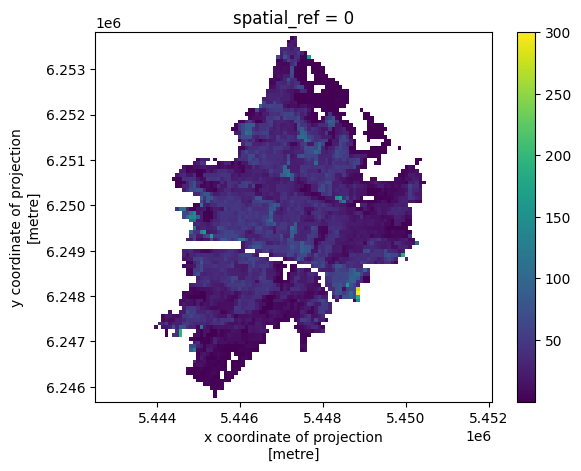

In [37]:
pob_redistribuida_enmascarada.plot()

In [34]:
total_censo

np.int64(101722)

## Vulnerability

In [ ]:
# pull in the census vulnerability data
# calculate poverty

array([[<Axes: title={'center': 'porcentaje_privacion'}>]], dtype=object)

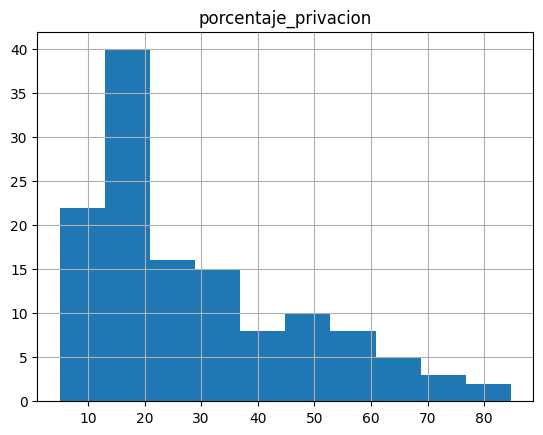

In [28]:
gdf.hist("porcentaje_privacion")

In [35]:
# Create poverty proportions raster at 100m resolution
geometrias_privacion = [
    (geom, valor)
    for geom, valor in zip(
        gdf.geometry,
        gdf["porcentaje_privacion"] / 100,  # Convert percentage to proportion
    )
]

raster_privacion = rasterize(
    geometrias_privacion,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

# Create population in poverty raster by multiplying redistributed population by poverty proportions
mascara_pob_privacion = (pob_redistribuida > 0) & (raster_privacion > 0)
pob_privacion = np.full_like(pob_redistribuida, 0, dtype=np.float64)
pob_privacion[mascara_pob_privacion] = (
    pob_redistribuida[mascara_pob_privacion] * raster_privacion[mascara_pob_privacion]
)

# Create xarray DataArray for the poverty population raster
pob_privacion_da = xr.DataArray(
    pob_privacion,
    coords={"y": ghsl_clipped.y, "x": ghsl_clipped.x},
    dims=["y", "x"],
    attrs=ghsl_clipped.attrs.copy(),
)

pob_privacion_da = pob_privacion_da.rio.write_crs(USE_CRS)

# Mask zero values
pob_privacion_enmascarada = pob_privacion_da.where(pob_privacion_da > 0)

# Calculate total population in poverty
total_pob_privacion = pob_privacion[pob_privacion > 0].sum()
print(f"Total population in poverty: {total_pob_privacion:,.0f}")
print(
    f"Percentage of redistributed population in poverty: {(total_pob_privacion / total_redistribuido) * 100:.1f}%"
)

Total population in poverty: 31,990
Percentage of redistributed population in poverty: 31.6%


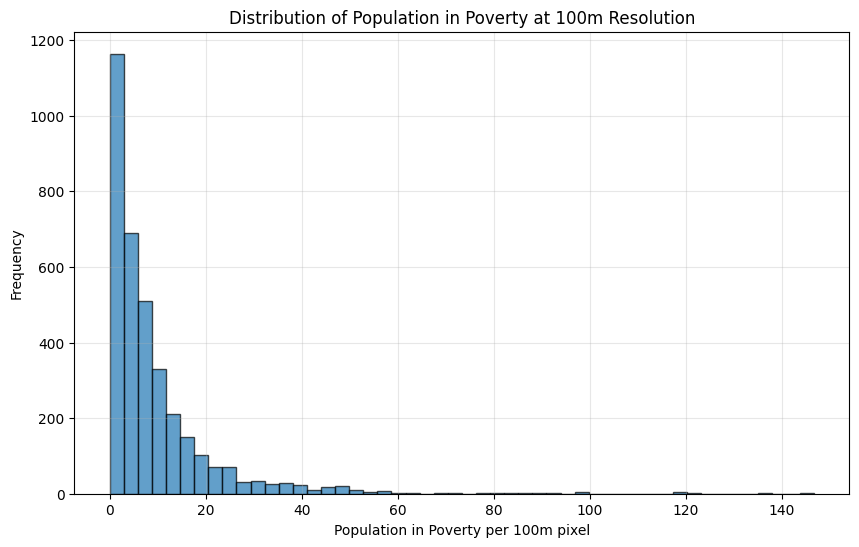

In [36]:
# Histogram of poverty population values
plt.figure(figsize=(10, 6))
pob_privacion_values = pob_privacion[pob_privacion > 0]
plt.hist(pob_privacion_values, bins=50, alpha=0.7, edgecolor="black")
plt.xlabel("Population in Poverty per 100m pixel")
plt.ylabel("Frequency")
plt.title("Distribution of Population in Poverty at 100m Resolution")
plt.grid(True, alpha=0.3)
plt.show()

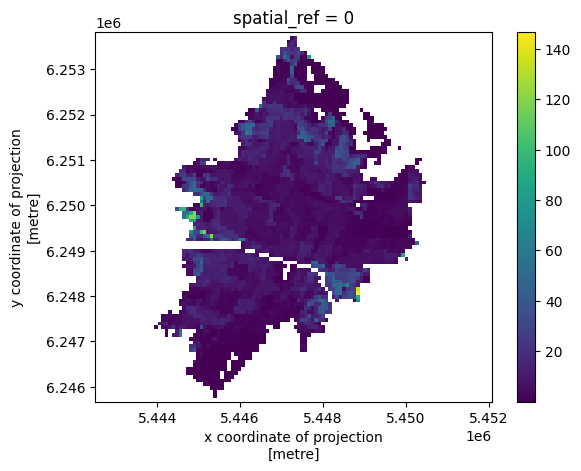

In [39]:
pob_privacion_enmascarada.plot()

## Risk

In [ ]:
# calculate the total population in the area,
# total population in poverty
# population in areas of high hazard
# pop in poverty in areas of high hazard

In [50]:
import rasterio.enums

# Crear máscara binaria para top 25% de valores LST
percentil_75 = LST_urban.quantile(0.75, dim=None).values
mascara_top25 = (LST_urban >= percentil_75).astype(int)

# Función para calcular exposición
def calcular_exposicion(pob_raster, lst_urban, mascara, nombre):
    """Calcula población expuesta al top 25% de calor."""
    # Reprojectar si es necesario
    if pob_raster.rio.crs != lst_urban.rio.crs:
        pob_reproyectado = pob_raster.rio.reproject(
            lst_urban.rio.crs,
            resampling=rasterio.enums.Resampling.nearest,
        )
    else:
        pob_reproyectado = pob_raster
    
    # Resamplear a 30m y desagregar (dividir por 11.11)
    pob_30m = pob_reproyectado.rio.reproject_match(
        lst_urban,
        resampling=rasterio.enums.Resampling.nearest,
    ) / 11.1111
    
    # Calcular totales
    total = pob_30m.sum().values
    expuesta = (pob_30m * mascara).sum().values
    porcentaje = (expuesta / total * 100) if total > 0 else 0.0
    
    print(f"{nombre}:")
    print(f"  Total: {total:,.0f}")
    print(f"  Expuesta al top 25%: {expuesta:,.0f}")
    print(f"  Porcentaje: {porcentaje:.2f}%")
    
    return {'total': total, 'expuesta': expuesta, 'porcentaje': porcentaje}

# Calcular exposición
print("RESUMEN DE EXPOSICIÓN")
print("="*50)
resultados_total = calcular_exposicion(
    pob_redistribuida_enmascarada,
    LST_urban,
    mascara_top25,
    "Población Total"
)
resultados_pobreza = calcular_exposicion(
    pob_privacion_enmascarada,
    LST_urban,
    mascara_top25,
    "Población en Pobreza"
)

RESUMEN DE EXPOSICIÓN
Población Total:
  Total: 104,248
  Expuesta al top 25%: 10,440
  Porcentaje: 10.01%
Población en Pobreza:
  Total: 33,092
  Expuesta al top 25%: 4,828
  Porcentaje: 14.59%


## Proposed Interventions

In [ ]:
# look at the WRI article really quickly on things that could be tried
# what kind of interventions might you suggest here? why?

In [ ]:
# if we have time, maybe pull in the tree cover dataset and compare hot areas to tree cover
# talk about this in terms of interventions

Bounds: [[-33.93121048230672, -60.60690676827699], [-33.859709803205114, -60.53613568794173]]
Array shape: (294, 291)
Valid pixels: 42998



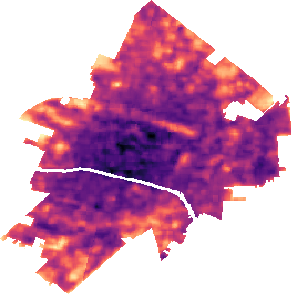

In [ ]:
import folium
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import base64
from io import BytesIO

# Reproject to WGS84
lst_wgs84 = LST_urban.rio.reproject("EPSG:4326") if LST_urban.rio.crs != "EPSG:4326" else LST_urban

# Squeeze all extra dimensions and get 2D array
lst_array = lst_wgs84.squeeze().values


# Handle NaN/masked values
lst_array = np.ma.filled(lst_array, np.nan) if np.ma.is_masked(lst_array) else lst_array
valid_mask = ~np.isnan(lst_array) & np.isfinite(lst_array)

if not valid_mask.any():
    print("Warning: No valid LST values found!")
else:
    # Normalize using only valid values
    vmin, vmax = np.nanmin(lst_array[valid_mask]), np.nanmax(lst_array[valid_mask])
    normalized = np.full_like(lst_array, 0, dtype=np.float32)
    normalized[valid_mask] = (lst_array[valid_mask] - vmin) / (vmax - vmin)
    
    # Apply magma colormap - set invalid pixels to transparent
    cmap = plt.get_cmap('magma')
    rgba = cmap(normalized)  # Keep alpha channel
    rgba[~valid_mask, 3] = 0  # Make invalid pixels transparent
    rgba = (rgba * 255).astype(np.uint8)
    
    # Convert to PIL Image with transparency
    img = Image.fromarray(rgba, 'RGBA')
    buffer = BytesIO()
    img.save(buffer, format='PNG')
    img_base64 = base64.b64encode(buffer.getvalue()).decode()
    
    # Get bounds - folium uses [[south, west], [north, east]]
    bounds = lst_wgs84.rio.bounds()  # (minx, miny, maxx, maxy)
    bounds_list = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]  # [[south, west], [north, east]]
    
    # Center point
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Map with satellite basemap
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=13,
        tiles=None
    )
    
    # Satellite basemap
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite',
        overlay=False,
    ).add_to(m)
    
    # Add overlay using base64
    img_overlay = folium.raster_layers.ImageOverlay(
        image=f'data:image/png;base64,{img_base64}',
        bounds=bounds_list,
        opacity=0.7,
        interactive=True,
        name='LST',
    )
    img_overlay.add_to(m)
    
    folium.LayerControl().add_to(m)
    
    m

display(m)